In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
def get_ids_len(df):
    ids = []
    len_ids = []
    for id in tqdm(df["TRACK_ID"]):
        if not (id in ids):
            ids.append(id)
            len_ids.append(len(df[df["TRACK_ID"]==id]))
    return ids, len_ids

def filter_track_length(N,ids,len_ids):
    f_ids = []
    f_len = []
    for k in range(len(ids)):
        if len_ids[k] >= N:
            f_ids.append(ids[k])
            f_len.append(len_ids[k])
    return f_ids, f_len

def filter_df(df,f_ids):
    f_df = pd.DataFrame()
    for id in tqdm(f_ids):
        f_df = pd.concat((f_df,df[df["TRACK_ID"].to_numpy().astype('int') == id]))
    return f_df

def traj(id,df): 
    frames = np.sort(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    T = len(frames)
    pos = np.zeros((T,3))
    df_id = df[df["TRACK_ID"]==id]
    for t in range(T):
        pos[t,0] = df_id[df_id["FRAME"]==frames[t]]["POSITION_X"].values[0]
        pos[t,1] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Y"].values[0]
        pos[t,2] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Z"].values[0]
    return frames, pos
    

In [3]:
def df_to_traj(df):
    df = df[3:]
    df = df.astype({"TRACK_ID" : int, 
            "POSITION_X" : float,
            "POSITION_Y" : float,
            "POSITION_Z" : float,
            "POSITION_T" : float,
            "FRAME" : int
            })
    
    ids, len_ids = get_ids_len(df)
    f_ids, f_len = filter_track_length(100,ids,len_ids)
    f_df = filter_df(df,f_ids)
    
    trajs = []
    for id in tqdm(f_ids):
        trajs.append(traj(id,f_df))
    return trajs

In [4]:
data = "FWF001"

df_P = pd.read_csv("Automation_out/"+data+"_Proximal_spots.csv",encoding='cp1252')
df_D = pd.read_csv("Automation_out/"+data+"_Distal_spots.csv",encoding='cp1252')

/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_3489/393311820.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_P = pd.read_csv("Automation_out/"+data+"_Proximal_spots.csv",encoding='cp1252')
/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_3489/393311820.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_D = pd.read_csv("Automation_out/"+data+"_Distal_spots.csv",encoding='cp1252')


In [5]:
trajs_P = df_to_traj(df_P)
trajs_D = df_to_traj(df_D)

100%|██████████| 134/134 [00:14<00:00,  9.06it/s]


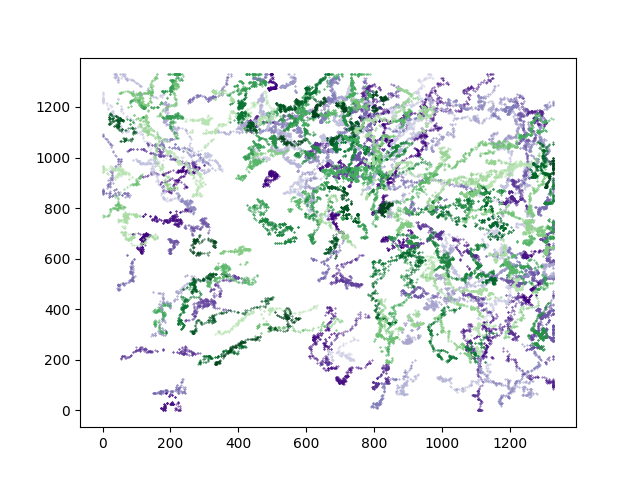

In [6]:
%matplotlib widget
fig2d = plt.figure()
ax2d = fig2d.add_subplot()

N = 14
colors = plt.cm.Purples(np.linspace(0.3,1,N))
clen = len(colors)
cind = 0
for tr in trajs_P:
    ax2d.plot(tr[1][:,0],tr[1][:,1],'.',markersize=0.7,color=colors[cind%clen,:])
    cind += 1
    
colors = plt.cm.Greens(np.linspace(0.3,1,N))
clen = len(colors)
cind = 0
for tr in trajs_D:
    ax2d.plot(tr[1][:,0],tr[1][:,1],'.',markersize=0.7,color=colors[cind%clen,:])
    cind += 1

plt.show()

In [9]:
trajs_P

[(array([ 49,  50,  51,  52,  53,  55,  56,  57,  58,  59,  60,  61,  62,
          63,  64,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
          77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
          90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
         103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
         116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
         129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
         142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153]),
  array([[1193.4011934,  819.000819 ,    0.       ],
         [1196.001196 ,  808.6008086,    0.       ],
         [1188.2011882,  816.4008164,    0.       ],
         [1188.2011882,  824.2008242,    0.       ],
         [1185.6011856,  829.4008294,    0.       ],
         [1177.8011778,  829.4008294,    0.       ],
         [1175.2011752,  826.8008268,    0.       ],
         [1175.2011752,  826.8008268,   